# Burlington Housing EDA Notebook

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import quandl
from geopy.distance import great_circle
%matplotlib inline 


### First steps 
* Import dataset into local memory. 
* Set correct datatypes
* create new columns and drop unecessary ones

In [5]:
# use pandas to read a csv file from Burlington, VT open data
df = pd.read_csv("https://opendata.arcgis.com/datasets/276ccff527454496ac940b60a2641dda_0.csv")

# create latitude and longitude columns - drop the old uncessesary column
locFixes = df['PropertyCenterPoint'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Latitude', 1:'Longitude'})
df.drop('PropertyCenterPoint', 1, inplace = True)

# create full and half bath columns - drop the old uncessesary column
bathFixes = df['Baths'].str.split('/', expand=True).rename(columns={0:'Full_Baths', 1:'Half_Baths'})
df.drop('Baths', 1, inplace = True)

# create a dataframe with the new variables - set the correct datatype
df = pd.concat([df, locFixes,bathFixes],axis=1)
df['Half_Baths'] = pd.to_numeric(df['Half_Baths'])
df['Full_Baths'] = pd.to_numeric(df['Full_Baths'])

#create a year column 
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
df['Year'] = df['SaleDate'].apply(lambda row: row.year)


print("Dataframe dimensions:", df.shape)


Dataframe dimensions: (10832, 42)


### Joining data 
* Get Vermont GDP data from Quandl 
* Get Vermont Housing Price Index from Quandl

In [6]:
# get Vermont GDP and Housing Price Index from Quandl
VTGDP = quandl.get("FRED/VTNGSP", start_date="1931-01-01")
VTHPI = quandl.get("FRED/VTSTHPI", start_date="1931-01-01")

# Calculate yearly means 
VTGDP = VTGDP.resample('A').mean()
VTGDP = VTGDP.reset_index()

# Calculate yearly means
VTHPI = VTHPI.resample('A').mean()
VTHPI = VTHPI.reset_index()

# Create a year columns to join on 
VTGDP['Year'] = VTGDP['Date'].apply(lambda row: row.year)
VTHPI['Year'] = VTHPI['Date'].apply(lambda row: row.year)

#rename columns and drop the Date column - It won't be needed
VTGDP = VTGDP.rename(columns = {'Value': 'VermontGDP'})
VTHPI = VTHPI.rename(columns = {'Value': 'VermontHPI'})
VTGDP = VTGDP.drop('Date', 1)
VTHPI = VTHPI.drop('Date', 1)

# Join the GDP and HPI data with the BTV housing data 
df = pd.merge(df,VTGDP, 'left', on = 'Year')
df = pd.merge(df,VTHPI, 'left', on = 'Year')
print("Dataframe dimensions after join:", df.shape)

Dataframe dimensions after join: (10832, 44)


# Exploratory Plots 

**Sale Price Column**

Let me start by first using a few histograms and numerical summaries to understand the outcome variable Sale Price

In [7]:
# There are no null values in the SalePrice column

df['SaleDate'].isna().sum()

6196

Histogram of Sale Price

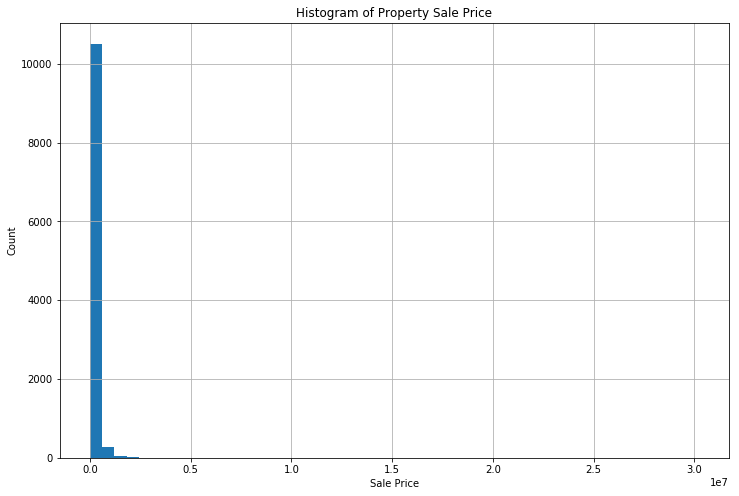

In [8]:
plt.figure(figsize = (12,8))
df['SalePrice'].hist(bins = 50)
plt.title("Histogram of Property Sale Price")
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.savefig("saleprice.png")
plt.show()

Wow that outcome is skwewed! Lets zoom in a little bit.

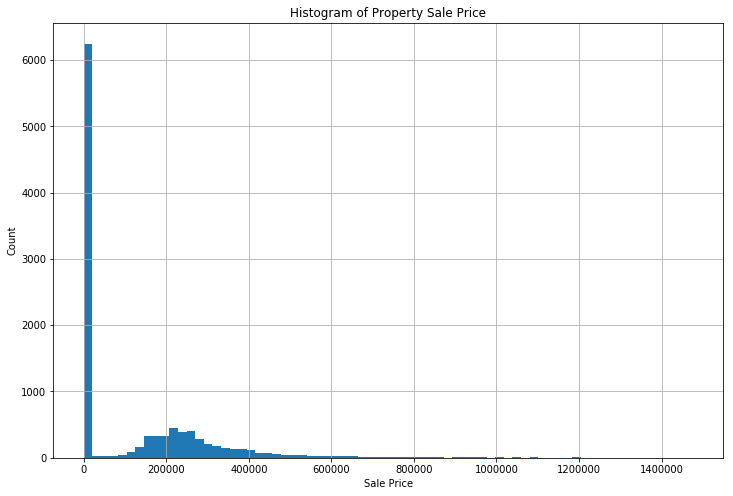

In [9]:
#subset to properties less than 1500000
mil = df.query('SalePrice<1500000')
plt.figure(figsize = (12,8))
mil['SalePrice'].hist(bins = 'auto')
plt.title("Histogram of Property Sale Price")
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.savefig("saleprice.png")
plt.show()

**Observations:**

* Mode around 200000
* Lots of 0s!
* Distribution extremely skwed

**Other Columns**

With pandas we can easily plot all the numeric columns 

**Numeric Columns:**

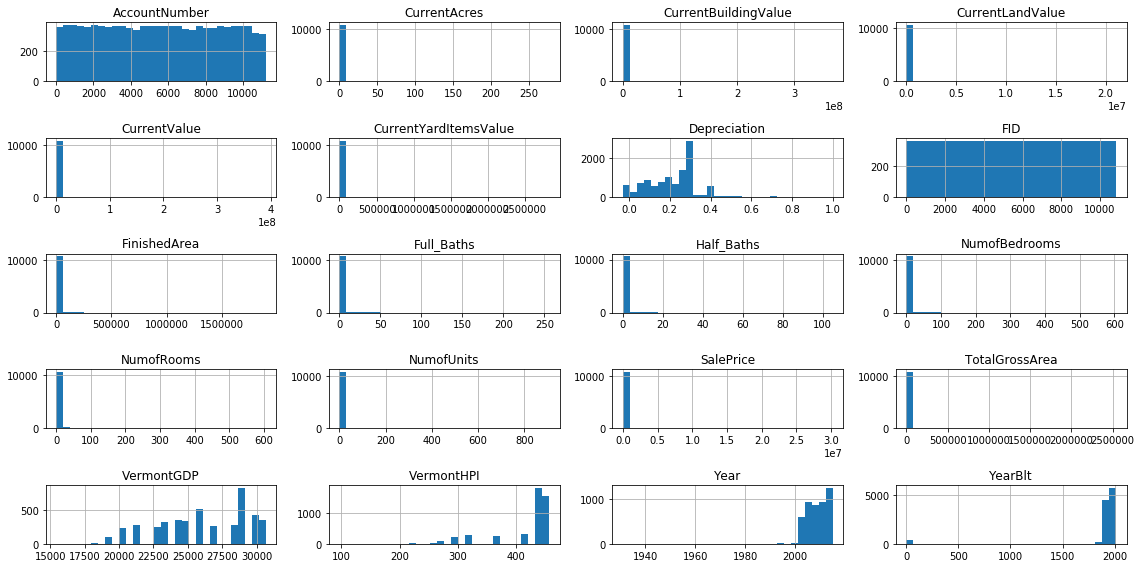

In [10]:
df.hist(figsize = (16, 8), bins = 30)
plt.tight_layout()
plt.show()

Observations:
* Many of the distributions are skewed and non-normal
* Account Number and FID likely are just foreign or primary keys from databases and likely should be deleted

**Object Type Columns:**

There are 25 object type columns - I don't wanna visualize these all. Lets subset these columns out and look at there names.

In [11]:
objects = []
for i in df.columns:
    if df[i].dtype == 'object':
        objects.append(i)
    else:
        pass
n = len(objects)
print(n)        

23


In [12]:
# print the first 10
for i, j in zip(range(len(objects)), objects):
    print(j)
    if i == 10:
        break

ParcelID
SpanNumber
StreetNumber
AlternateNumber
StreetName
Unit
CuO1LastName
CuO1FirstName
CuO2LastName
CuO2FirstName
CuO3LastName


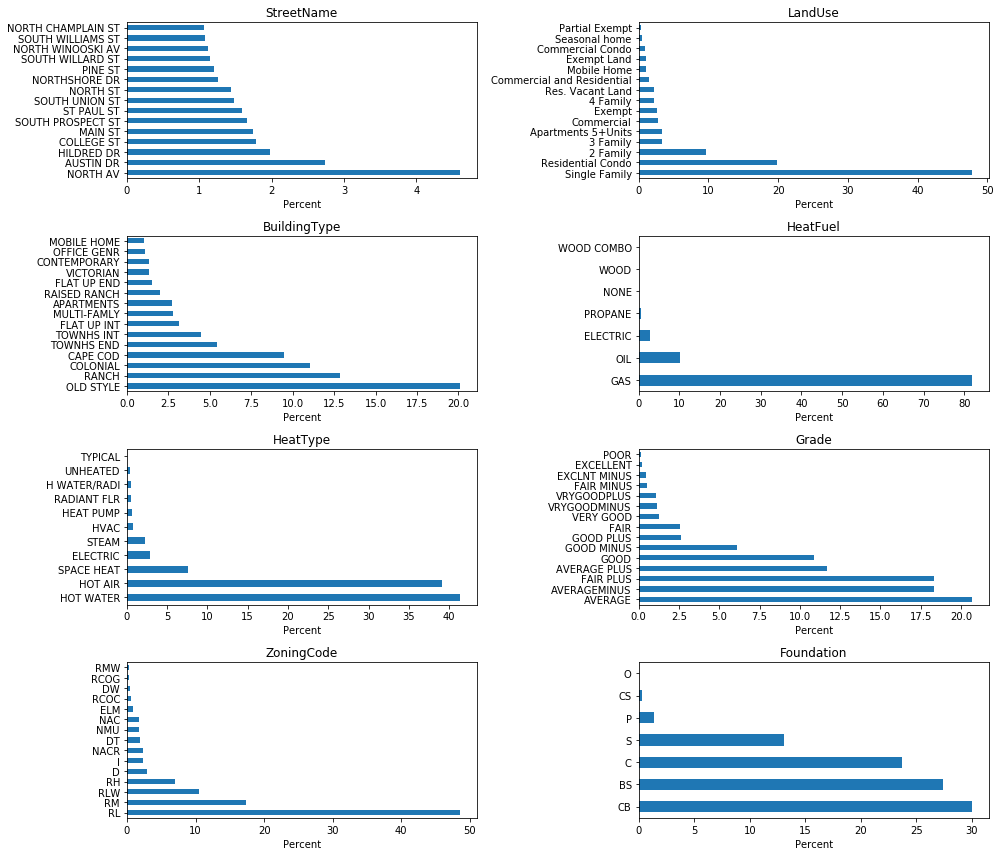

In [13]:
selected = ['StreetName', 'LandUse', 'BuildingType', 'HeatFuel', 'HeatType','Grade', 'ZoningCode', 'Foundation']
fig, ax = plt.subplots(4,2, figsize = (14,12))
ax = ax.ravel()
j = 0
for i in selected:
    x = (df[i].value_counts() / len(df[i]))
    x = x * 100
    x = x.head(15)
    x.plot(ax = ax[j], kind = 'barh', color = 'C0')
    ax[j].set_title(i)
    ax[j].set_xlabel('Percent')
    j += 1
plt.tight_layout()

Observations:

* A little over 4% of the sold houses were on North Ave. This is the largest percentage. This makes sense because North Ave is a long street with many houses

* Just under 50% of the sold properties were single family homes. Just under 70% of properties are either single family homes or residential condos. Since these property types are similar and make up most of the dataset it might make sense to only predict them.

* Hot air and Hot Water make up about 80% of the heattypes in Burlington 

* Most properties have the average grade - this is expected 

**Count of Null Values**

More than 50% of the VermontGDP and HPI columns are missing. This is ok because these time series will be easy to impute.

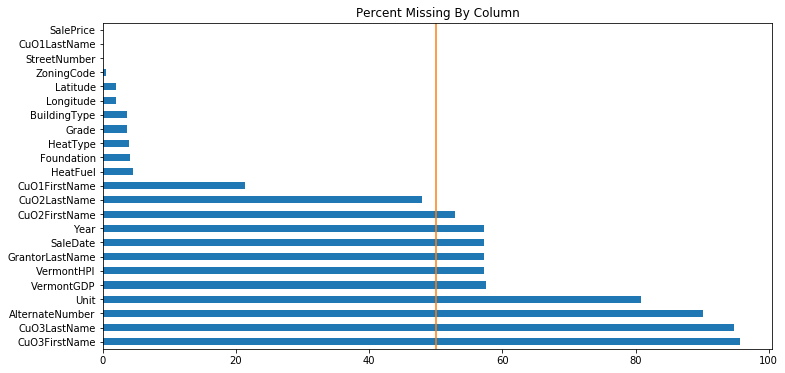

In [14]:
missing = pd.Series(df.isna().sum()/len(df)).sort_values(0, ascending=False).head(23)
missing = missing * 100
missing.plot(kind='barh', legend = False,figsize = (12,6), color = 'C0')
plt.title('Percent Missing By Column')
plt.axvline(50, color = 'C1')


**Time Series Plots**

/anaconda3/envs/Main/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


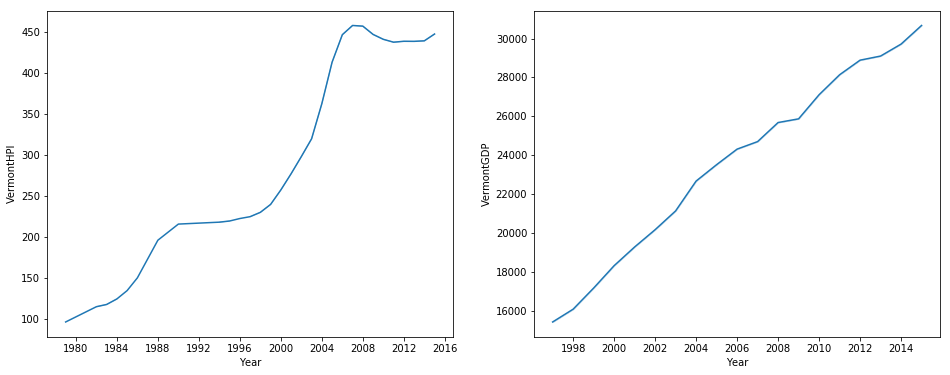

In [15]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,2, figsize = (16, 6))
ax = ax.ravel()
sns.lineplot(x="Year", y="VermontHPI", data = df, ax = ax[0])
sns.lineplot(x="Year", y="VermontGDP", data = df, ax = ax[1])
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

It's easy to quickly see that we have HPI data going farther back than we do GDP data.  

**Creating the Modeling Matrix**

It has already been noted that most of the properties that have sold are either Single Family of Residential Condo properities. Domain knowledge (living in the Burlington area my whole life) tells me that these types of properties are often similar and owned by similar kinds of people. 

I will subset the dataframe to only include single family and residential condo properties

In [43]:
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
modeldf = df.drop(['AccountNumber', 'ParcelID', 'SpanNumber', 'StreetNumber',
       'AlternateNumber', 'Unit', 'CuO1LastName',
       'CuO1FirstName', 'CuO2LastName', 'CuO2FirstName', 'CuO3LastName',
       'CuO3FirstName','LegalReference', 'GrantorLastName', 'FID'], axis = 1)
modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])
modeldf['Sale_Year'] = modeldf['SaleDate'].apply(lambda row: row.year)
modeldf.drop('SaleDate', axis=1, inplace= True)
modeldf = modeldf[(modeldf['LandUse'] == "Single Family") | (modeldf['LandUse'] == "Residential Condo")]
modeldf = modeldf[modeldf['SalePrice']> 0]
modeldf = modeldf.sort_values('Year')
modeldf['VermontGDP'] = modeldf['VermontGDP'].fillna(method='ffill')
modeldf['VermontHPI'] = modeldf['VermontHPI'].fillna(method='ffill')
modeldf = modeldf.dropna()

**Add distance features:**

In [17]:
from geopy.distance import great_circle

# convert latitude and longitude to numeric
modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])

#loop over these columns and create a list of the differences between each observation and city hall
distances = []
for i, j in zip(modeldf['Latitude'], modeldf['Longitude']):
    val = (i, j)
    Cityhall = (44.47647568031712, -73.21353835752235)
    dist = great_circle(val,Cityhall).miles
    distances.append(dist)
modeldf['Distances'] = distances

/anaconda3/envs/Main/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


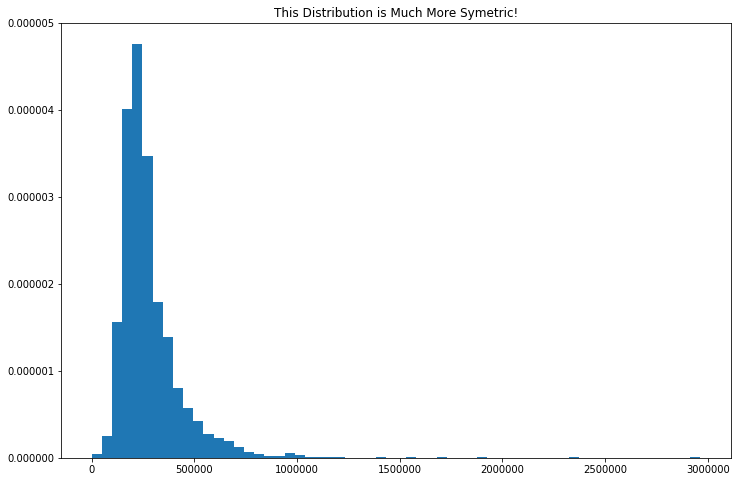

In [41]:
plt.figure(figsize = (12, 8))
plt.hist(modeldf['SalePrice'], bins = 60, normed = True)
plt.title('This Distribution is Much More Symetric!')
plt.show()

Lets look at a correlation matrix of the variables.

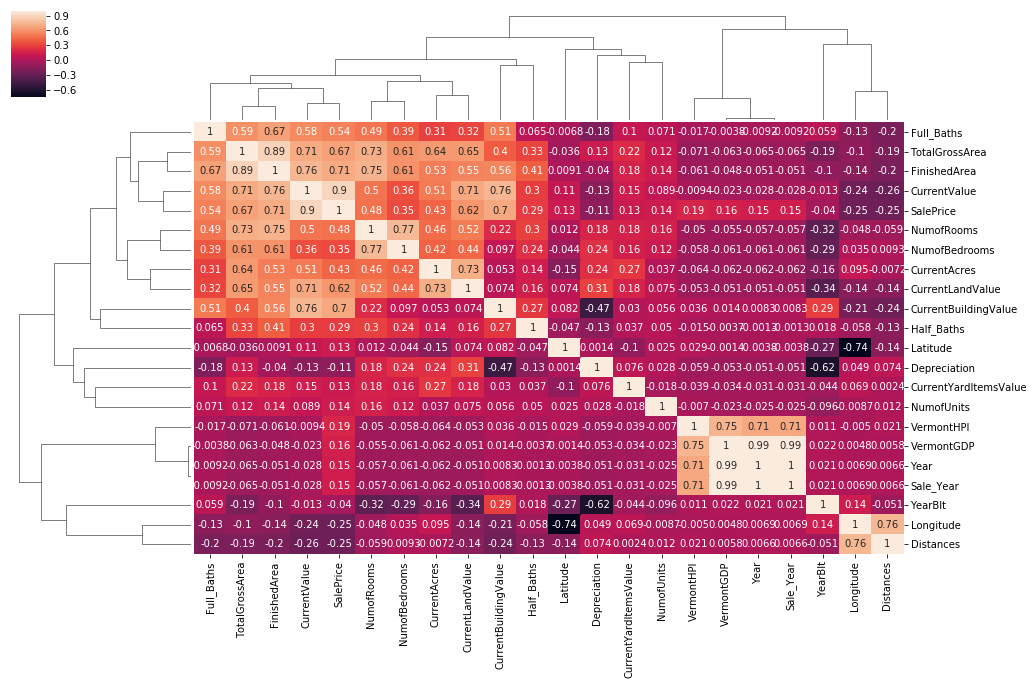

In [20]:
cormat = modeldf.corr()

sns.clustermap(cormat, annot = True)
plt.gcf().set_size_inches(16, 10)

**Observations:**
* Many of the Numeric Variables are correlated.  This can be a problem for simple linear models, but doesn't hurt more flexible models like decision trees or neural networks

* Current Value has the highest correlation with Sale Price. This is expected because they reflect alot of the same information

/anaconda3/envs/Main/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/Main/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


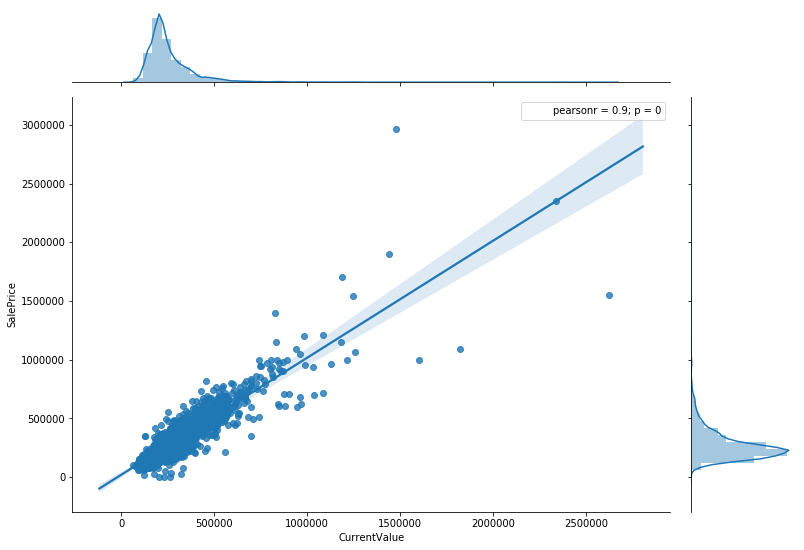

In [44]:
j = sns.jointplot('CurrentValue', 'SalePrice', modeldf,kind ='reg')
import scipy.stats as stats
j.annotate(stats.pearsonr)
plt.gcf().set_size_inches(11.7, 8)
plt.savefig('CurrentValueSalePricecorr.png')
plt.show()

In [118]:
print('Current Value explains {}% of the variability in Sale Price'.format(0.9 ** 2 * 100))

Current Value explains 81.0% of the variability in Sale Price


The ultimate goal will be to make a model that works better than this simple linear regression, but also is quite simple like it. This will help people accurately price single family and residential condo homes. I would like to use a model that does not just return a scalar prediction, but a full posterior, so it is possible to evaluate the probability that a house sells for at least a certain price.

**Data processing function:**

After going through this EDA we've changed the data a bit, and created a model matrix. I am going to rap all this logic into a function so that I can put this in a seperate .py file and import it and call it rather than copying and pasting code.

In [119]:
def Parse_btv_house():
    import pandas as pd 
    import numpy as np 
    import matplotlib.pyplot as plt 
    import seaborn as sns 
    import quandl
    from geopy.distance import great_circle
    # use pandas to read a csv file from Burlington, VT open data
    df = pd.read_csv("https://opendata.arcgis.com/datasets/276ccff527454496ac940b60a2641dda_0.csv")

    # create latitude and longitude columns - drop the old uncessesary column
    locFixes = df['PropertyCenterPoint'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Latitude', 1:'Longitude'})
    df.drop('PropertyCenterPoint', 1, inplace = True)

    # create full and half bath columns - drop the old uncessesary column
    bathFixes = df['Baths'].str.split('/', expand=True).rename(columns={0:'Full_Baths', 1:'Half_Baths'})
    df.drop('Baths', 1, inplace = True)

    # create a dataframe with the new variables - set the correct datatype
    df = pd.concat([df, locFixes,bathFixes],axis=1)
    df['Half_Baths'] = pd.to_numeric(df['Half_Baths'])
    df['Full_Baths'] = pd.to_numeric(df['Full_Baths'])

    #create a year column 
    df['SaleDate'] = pd.to_datetime(df['SaleDate'])
    df['Year'] = df['SaleDate'].apply(lambda row: row.year)



    # get Vermont GDP and Housing Price Index from Quandl
    VTGDP = quandl.get("FRED/VTNGSP", start_date="1931-01-01")
    VTHPI = quandl.get("FRED/VTSTHPI", start_date="1931-01-01")

    # Calculate yearly means 
    VTGDP = VTGDP.resample('A').mean()
    VTGDP = VTGDP.reset_index()

    # Calculate yearly means
    VTHPI = VTHPI.resample('A').mean()
    VTHPI = VTHPI.reset_index()

    # Create a year columns to join on 
    VTGDP['Year'] = VTGDP['Date'].apply(lambda row: row.year)
    VTHPI['Year'] = VTHPI['Date'].apply(lambda row: row.year)

    #rename columns and drop the Date column - It won't be needed
    VTGDP = VTGDP.rename(columns = {'Value': 'VermontGDP'})
    VTHPI = VTHPI.rename(columns = {'Value': 'VermontHPI'})
    VTGDP = VTGDP.drop('Date', 1)
    VTHPI = VTHPI.drop('Date', 1)

    # Join the GDP and HPI data with the BTV housing data 
    df = pd.merge(df,VTGDP, 'left', on = 'Year')
    df = pd.merge(df,VTHPI, 'left', on = 'Year')

    df['SaleDate'] = pd.to_datetime(df['SaleDate'])
    modeldf = df.drop(['AccountNumber', 'ParcelID', 'SpanNumber', 'StreetNumber',
           'AlternateNumber', 'Unit', 'CuO1LastName',
           'CuO1FirstName', 'CuO2LastName', 'CuO2FirstName', 'CuO3LastName',
           'CuO3FirstName','LegalReference', 'GrantorLastName', 'FID'], axis = 1)
    modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
    modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])
    modeldf['Sale_Year'] = modeldf['SaleDate'].apply(lambda row: row.year)
    modeldf.drop('SaleDate', axis=1, inplace= True)
    modeldf = modeldf[(modeldf['LandUse'] == "Single Family") | (modeldf['LandUse'] == "Residential Condo")]
    modeldf = modeldf[modeldf['SalePrice']> 0]
    modeldf = modeldf.sort_values('Year')
    modeldf['VermontGDP'] = modeldf['VermontGDP'].fillna(method='ffill')
    modeldf['VermontHPI'] = modeldf['VermontHPI'].fillna(method='ffill')
    modeldf = modeldf.dropna()

    from geopy.distance import great_circle

    # convert latitude and longitude to numeric
    modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
    modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])

    #loop over these columns and create a list of the differences between each observation and city hall
    distances = []
    for i, j in zip(modeldf['Latitude'], modeldf['Longitude']):
        val = (i, j)
        Cityhall = (44.47647568031712, -73.21353835752235)
        dist = great_circle(val,Cityhall).miles
        distances.append(dist)
    modeldf['Distances'] = distances
    return modeldf



Last but not least we will see how the two different types of property differ across the highly correlated variables

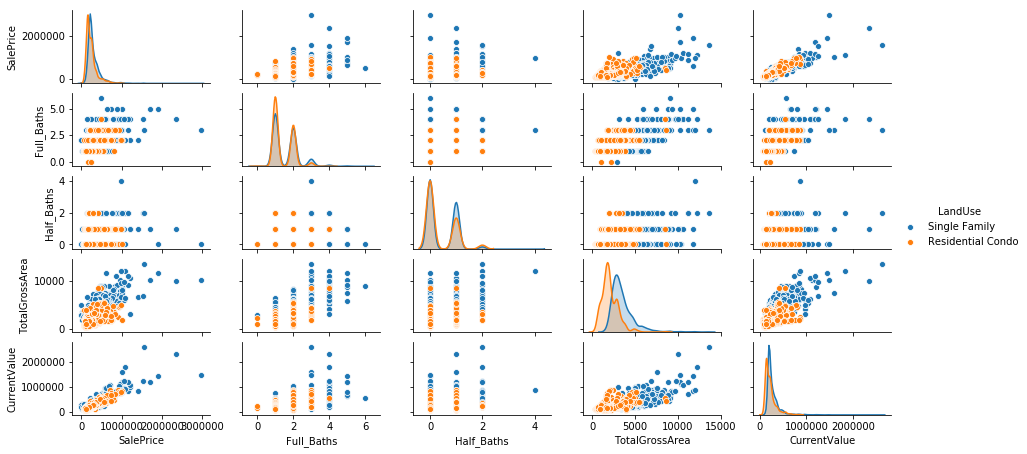

In [38]:
high_corr = ['SalePrice','Full_Baths','Half_Baths', 'TotalGrossArea', 'CurrentValue', 
             'LandUse']

pars = modeldf[high_corr]
sns.pairplot(pars, hue='LandUse')
plt.gcf().set_size_inches(14, 6)
plt.show()